# imglyb basics

[*imglyb*](https://github.com/hanslovsky/imglib2-imglyb) gives you shared memory between *numpy* and *imglib2*! It does so by accessing native memory in Java through `UNSAFE`. The required accesses for *imglib2* data structures are implemented in [*imglib2-unsafe*](https://github.com/imglib/imglib2-unsafe). The JVM needs to be started from within a running Python process to enable shared memory, which happens in the [*PyJNIus*](https://github.com/kivy/pyjnius) module. *imglib2-imglyb* (Java) and *imglyb* (Python) provide a convenience layer  that exposes useful Java classes on the Python side and translates between *numpy* and *imglib2* data types.

## Importing imglyb and jnius
The *jnius* module starts the JVM on import. Once the JVM is running, it cannot be restarted and JVM parameters or the classpath cannot be modified anymore. *imglyb* modifies the classpath based on environment variables and thus must be imported before *jnius* and *scyjava* (*cf* below). That includes imports of the form of
```python
from jnius import *
from scyjava import *
```
but not
```python
import jnius_config
import scyjava_config
```
### Environment variables
 - Required
   - `JAVA_HOME` Path to Java SDK, e.g. `/usr/lib/jvm/default`
   - `PYJNIUS_JAR` Path to `pyjnius.jar`
   
Additional Maven repositories and dependencies can be added as Maven coordinate endpoints through the `scijava_config`:
```python
import scyjava_config
scyjava_config.add_repositories(identifier='https://maven.repository/url')
scyjava_config.add_endpoints('groupId:artifactId[:version]')
```
Single jars and directories can be added to the classpath without dependency resolution through the `jnius_config` API:
```
import jnius_config
jnius_config.add_classpath('my.jar', '/path/to/directory/containing/class/files')
```
Generally, maven endpoints are preferred over individual jars or classpath modifications.

In [1]:
import jnius_config

import glob

import os

# You can set the environment from python if it is not set yet:
if not os.environ.get( 'PYJNIUS_JAR' ):
    os.environ[ 'PYJNIUS_JAR' ] = os.path.expanduser( '~/imglyb-jars/pyjnius.jar' )
if not os.environ.get( 'JAVA_HOME' ):
    os.environ[ 'JAVA_HOME' ] = '/usr/lib/jvm/default'

# Add all Fiji jars to the classpath

fiji_app_dir = os.path.expanduser( '~/local/Fiji.app' )

jars        = glob.glob( f'{fiji_app_dir}/jars/*.jar' )
plugins     = glob.glob( f'{fiji_app_dir}/plugins/*.jar' )
bio_formats = glob.glob( f'{fiji_app_dir}/jars/bio-formats/*.jar' )

for jar in jars + plugins + bio_formats:
    jnius_config.add_classpath( jar )
    
# alternatively set the 'CLASSPATH' environment variable :
os.environ[ 'CLASSPATH' ] = jnius_config.split_char.join( jars + plugins + bio_formats )
        
# this is equivalent to setting the CLASSPATH variable before starting Python:
# export CLASSPATH=`ls -1 ~/local/Fiji.app/jars/*.jar ~/local/Fiji.app/plugins/*.jar ~/local/Fiji.app/jars/bio-formats/*.jar | tr '\n' ':'`

import imglyb
import imglyb.util as util
import imglyb.types as types

# import jnius only after importing imglyb
from jnius import autoclass, PythonJavaClass, cast, java_method

## Calls to Java from Python
 - Create instances of Java classes (`jnius.autoclass`)
 - Call static Java methods and access static members
 - Cast Java objects (`jnius.cast`)
 - Catch excecptions (`jnius.JavaException`)
 - Use python lists as Java arrays

In [2]:
from jnius import autoclass, cast, JavaException

# import java.util.ArrayList;
ArrayList = autoclass( 'java.util.ArrayList' )
# create instance
al = ArrayList()
# add elements to list
for c in 'Hello Dresden!':
    al.add( c )
print( al.toString() )

[H, e, l, l, o,  , D, r, e, s, d, e, n, !]


In [3]:
# access to static members and methods
Double = autoclass( 'java.lang.Double' )
Arrays = autoclass( 'java.util.Arrays' )
print( Double.NaN )
print( Arrays.toString( [1,2,3] ) )

nan
[1, 2, 3]


In [4]:
ArrayImgs    = autoclass( 'net.imglib2.img.array.ArrayImgs' )
single_pixel = ArrayImgs.doubles( [ 0.5 ], 1, 1, 1 )
Converters   = autoclass( 'net.imglib2.converter.Converters' )
converter    = autoclass( 'net.imglib2.converter.RealARGBConverter' )()
t            = autoclass( 'net.imglib2.type.numeric.ARGBType' )()

# Exception handling and info
try:
    cast( 'net.imglib2.type.numeric.real.DoubleType', ArrayImgs.doubles( 1 ).cursor().get() ).getRealDouble()
except JavaException as e:
    print( "e.classname    -- {}".format( e.classname ) )
    print( "e.innermessage -- {}".format( e.innermessage ) )
    for st in e.stacktrace:
        print( st )

e.classname    -- java.lang.ArrayIndexOutOfBoundsException
e.innermessage -- -1
java.lang.ArrayIndexOutOfBoundsException: -1
net.imglib2.img.basictypeaccess.array.AbstractDoubleArray.getValue(AbstractDoubleArray.java:61)
net.imglib2.type.numeric.real.DoubleType.get(DoubleType.java:108)
net.imglib2.type.numeric.real.DoubleType.getRealDouble(DoubleType.java:125)


In [5]:
# Exception handling and cast
try:
    argb = Converters.convert( single_pixel, converter, t )
except JavaException as e:
    print( "Could not convert!" )
    argb = Converters.convert( cast( 'net.imglib2.RandomAccessibleInterval', single_pixel ), converter, t )
    
util.Views.flatIterable( argb ).cursor().next().toString()

Could not convert!


'(r=128,g=128,b=128,a=255)'

## Implementing Java interfaces in Python
*PyJNIus* allows us to implement any Java interface (but not abstract classes) in pure Python.
Note that this does not currently work in Windows (https://github.com/kivy/pyjnius/issues).
This is how it is done ([reference](http://pyjnius.readthedocs.io/en/latest/api.html)):

In [6]:
from jnius import PythonJavaClass, java_method, autoclass # we need these modules of the jnius package

# Python style class definition, inherit from PythonJavaClass
class AddOne( PythonJavaClass ):
    # define the implemented interfaces (can be more than one)
    __javainterfaces__ = ['java/util/function/IntUnaryOperator']
    
    # Python constructor definition
    def __init__(self):
        # Call super class constructor. Without this, JVM will crash cryptically.
        super( AddOne, self ).__init__()
#         pass
        
    # Use decorators to define signature of overriden Java method.
    # This method takes an int as an argument and returns an int.
    # Python does not allow function signature overloading, so the
    # optional 'name' parameter can be used to specify the name of the
    # overridden Java method. It defaults to the name of the decorated
    # Python method.
    @java_method('(I)I', name='applyAsInt')
    def applyAsInt( self, operand ):
        return operand + 1

# Use class in Java call
stream = autoclass('java.util.stream.IntStream').range( 0, 10 )
ao = AddOne()
stream.map( ao ).toArray()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

## Debugging Python Exceptions in Java Interfaces
Python exceptions in Java interfaces cause cryptic error messages and are hard to debug. It helps to wrap suspicious code in the python variant of a `try ... catch` block:
```python
try:
    # run suspicious code
except ExceptionType as e:
    # handle e
```
Expect exceptions in the next few cells!

In [7]:
class IntUnary( PythonJavaClass ):
    __javainterfaces__ = ['java/util/function/IntUnaryOperator']
    
    def __init__(self, func = lambda x : x):
        super( IntUnary, self ).__init__()
        self.func = func
        
    @java_method('(I)I')
    def applyAsInt( self, operand ):
        return self.func( operand )

In [8]:
def raises( operand ):
    print( "Watch out, exception incoming!" )
    raise ValueError( "I do not like this value, no matter what!" )
    return 1

stream = autoclass('java.util.stream.IntStream').range( 0, 10 )
stream.map( IntUnary( raises ) ).toArray()

Watch out, exception incoming!


Traceback (most recent call last):
  File "jnius/jnius_jvm_dlopen.pxi", line 50, in jnius.create_jnienv
  File "jnius/jnius_proxy.pxi", line 76, in jnius.PythonJavaClass._invoke
  File "<ipython-input-7-0ef5c4680f1b>", line 10, in applyAsInt
    return self.func( operand )
  File "<ipython-input-8-1db6b454cec3>", line 3, in raises
    raise ValueError( "I do not like this value, no matter what!" )
ValueError: I do not like this value, no matter what!
Traceback (most recent call last):
  File "jnius/jnius_proxy.pxi", line 148, in jnius.py_invoke0
  File "jnius/jnius_conversion.pxi", line 479, in jnius.convert_python_to_jobject
TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'


JavaException: JVM exception occurred: java.lang.NullPointerException

In [9]:
def checks_and_prints( func ):
    def op( operand ):
        try:
            return func( operand )
        except Exception as e:
            print( "Caught exception: {}".format( e ) )
            raise e
    return op

stream = autoclass('java.util.stream.IntStream').range( 0, 10 )
stream.map( IntUnary( checks_and_prints( raises ) ) ).toArray()

Watch out, exception incoming!
Caught exception: I do not like this value, no matter what!


Traceback (most recent call last):
  File "jnius/jnius_jvm_dlopen.pxi", line 50, in jnius.create_jnienv
  File "jnius/jnius_proxy.pxi", line 76, in jnius.PythonJavaClass._invoke
  File "<ipython-input-7-0ef5c4680f1b>", line 10, in applyAsInt
    return self.func( operand )
  File "<ipython-input-9-c943c5deba55>", line 7, in op
    raise e
  File "<ipython-input-9-c943c5deba55>", line 4, in op
    return func( operand )
  File "<ipython-input-8-1db6b454cec3>", line 3, in raises
    raise ValueError( "I do not like this value, no matter what!" )
ValueError: I do not like this value, no matter what!
Traceback (most recent call last):
  File "jnius/jnius_proxy.pxi", line 148, in jnius.py_invoke0
  File "jnius/jnius_conversion.pxi", line 479, in jnius.convert_python_to_jobject
TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'


JavaException: JVM exception occurred: java.lang.NullPointerException

## Image IO and Conversion
Images can be read both through Java and Python. In general, any *numpy* `ndarray` with an equivalent *imglib2* `NativeType` can be wrapped as *imglib2* `RandomAccessibleInterval`. When reading images through *scifio* `ImgOpener` you will need to provide an appropriate image factory that creates images backed by native memory (`net.imglib2.python.ArrayImgWithUnsafeStoreFactory` from *imglib2-imglyb*) and `scifio.jar` from my [ImageJ update site](http://sites.imagej.net/Hanslovsky/). Once [scifio/scifio#350](https://github.com/scifio/scifio/issues/350) gets resolved using `scifio.jar` from that update site will become obsolete. Alternatively, you can build a snapshot of scifio master. Once Fiji comes with scifio version greater than or equal to 0.32.1 this will be obsoele.

### Load Image Through Python
There are many ways to load images in the Python world. I use *scikit-image* `skimage.io.imread` in this example but you can replace this with your favorite Python module that reads images into `numpy.ndarray`s, of course. If you don't have *scikit-image* on your machine you can easily get it through *pip* or *conda*.

Another nice example is reading *hdf5* files, which is very well supported and straight forward through the *h5py* python package. Any rectangular subset of a data set can be read as `numpy.ndarray` and thus wrapped into *imglib2* image data structures. This is demonstrated in the *bdv* notebook.

In [10]:
import numpy as np
import skimage.io

# url = 'http://emdata.janelia.org/api/node/822524777d3048b8bd520043f90c1d28/grayscale/isotropic/0_1/512_512/2200_2200_5000/jpg'
url = 'https://github.com/hanslovsky/imglyb-learnathon/raw/master/notebooks/basics/data/emdata.jpg'
ndarray = skimage.io.imread( url )

### Load Image Through *scifio*
The *scifio* `io.scif.img.ImgOpener` can open 

Note that this the *imagey* CPython REPL comes with a convenience function `open_img` that allows you to open images in one line.

In [11]:
Factory   = autoclass( 'net.imglib2.python.ArrayImgWithUnsafeStoreFactory' )
factory   = cast( 'net.imglib2.img.ImgFactory', Factory( imglyb.types.UnsignedByteType() ) )

ImgOpener = autoclass( 'io.scif.img.ImgOpener' )
opener    = ImgOpener()

img    = opener.openImgs( url, factory ).get( 0 )
img_np = imglyb.to_numpy( img.getImg() )

print( np.all( img_np == ndarray ) )

True


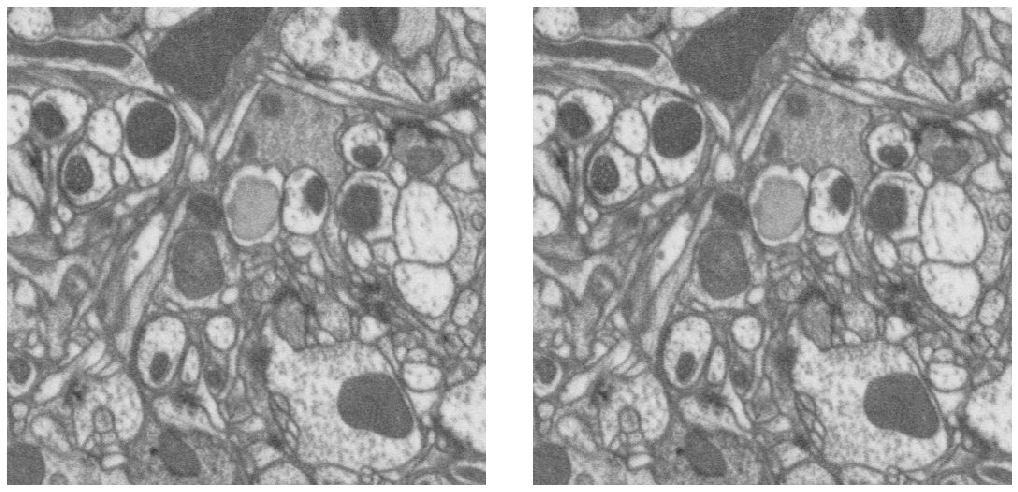

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt
fig = plt.figure( figsize=(18, 9 ) )
plt.subplot( 1, 2, 1 )
plt.imshow( ndarray, cmap = 'Greys_r', clim = ( 0, 256 ) )
plt.axis( 'off' )
plt.subplot( 1, 2, 2 )
plt.imshow( img_np, cmap = 'Greys_r', clim = ( 0, 256 ) )
plt.axis( 'off' )
plt.subplots_adjust( wspace=0.1 )

### But watch out for ARGB images!

Could not show imglib img: Invalid shape (3, 282, 330) for image data


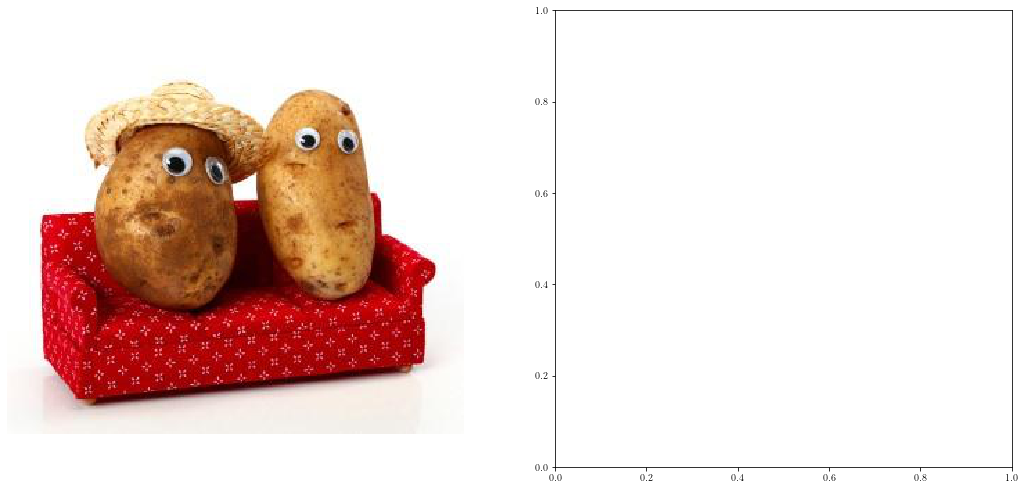

In [13]:
argb_url    = 'https://www.nerdtests.com/mq/testimages/167138_4f49b66c0cb4a87cc906.jpg'
ndarray_rgb = skimage.io.imread( argb_url )
img_rgb     = opener.openImgs( argb_url, factory ).get( 0 )
img_rgb_np  = imglyb.to_numpy( img_rgb.getImg() )

try:
    %matplotlib inline
    fig = plt.figure( figsize=(18, 9 ) )
    plt.subplot( 1, 2, 1 )
    plt.imshow( ndarray_rgb )
    plt.axis( 'off' )
    plt.subplot( 1, 2, 2 )
    plt.imshow( img_rgb_np )
    plt.axis( 'off' )
    plt.subplots_adjust( wspace=0.1 )
except TypeError as e:
    print( "Could not show imglib img: {}".format( e ) )

In [14]:
ndarray_rgb.shape, img_rgb_np.shape, tuple( img_rgb.dimension( d ) for d in range( 3 ) )

((282, 330, 3), (3, 282, 330), (330, 282, 3))

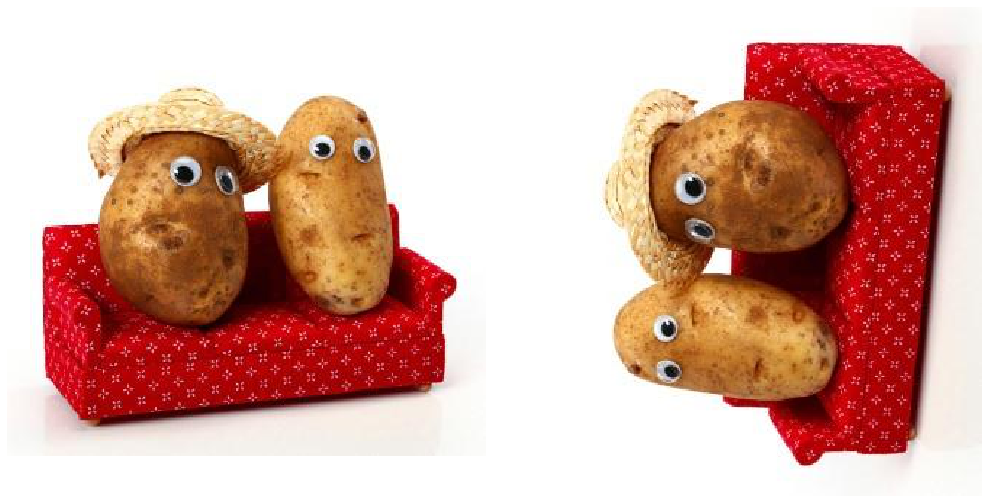

In [15]:
%matplotlib inline
fig = plt.figure( figsize=(18, 9 ) )
plt.subplot( 1, 2, 1 )
plt.imshow( ndarray_rgb )
plt.axis( 'off' )
plt.subplot( 1, 2, 2 )
plt.imshow( img_rgb_np.T )
plt.axis( 'off' )
plt.subplots_adjust(wspace=0.1)

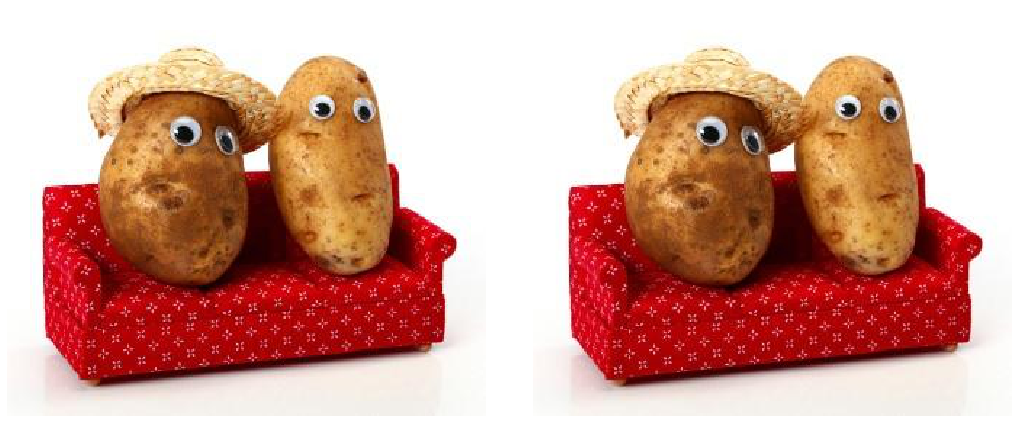

In [16]:
%matplotlib inline
fig = plt.figure( figsize=(18, 9 ) )
plt.subplot( 1, 2, 1 )
plt.imshow( ndarray_rgb )
plt.axis( 'off' )
plt.subplot( 1, 2, 2 )
plt.imshow( np.transpose( img_rgb_np, ( 1, 2, 0 ) ) )
plt.axis( 'off' )
plt.subplots_adjust( wspace=0.1 )